In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Cocoa beans Classification/

/gdrive/MyDrive/Cocoa beans Classification


In [4]:
ls

Fermented_Cocoa/  Moldy_Cocoa/  Whole_Beans_Cocoa/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Cocoa beans Classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 314 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Fermented_Cocoa', 'Moldy_Cocoa', 'Whole_Beans_Cocoa']

In [10]:
len(dataset)

6

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[165.      174.      183.     ]
  [165.      174.      183.     ]
  [165.      174.      183.     ]
  ...
  [166.27734 175.27734 184.27734]
  [167.5664  176.5664  185.5664 ]
  [168.      177.      186.     ]]

 [[164.85547 173.85547 182.85547]
  [164.89725 173.89725 182.89725]
  [165.02145 174.02145 183.02145]
  ...
  [166.36034 175.36034 184.36034]
  [167.5873  176.5873  185.5873 ]
  [168.      177.      186.     ]]

 [[164.42578 173.42578 182.42578]
  [164.59177 173.59177 182.59177]
  [165.08524 174.08524 183.08524]
  ...
  [166.60707 175.60707 184.60707]
  [167.6494  176.6494  185.6494 ]
  [168.      177.      186.     ]]

 ...

 [[164.14844 173.14844 180.14844]
  [164.27151 173.27151 180.27151]
  [164.63742 173.63742 180.63742]
  ...
  [163.41496 172.41496 179.41496]
  [163.53413 172.53413 179.53413]
  [163.57422 172.57422 179.57422]]

 [[163.28906 172.28906 179.28906]
  [163.53635 172.53635 179.53635]
  [164.27151 173.27151 180.27151]
  ...
  [162.24

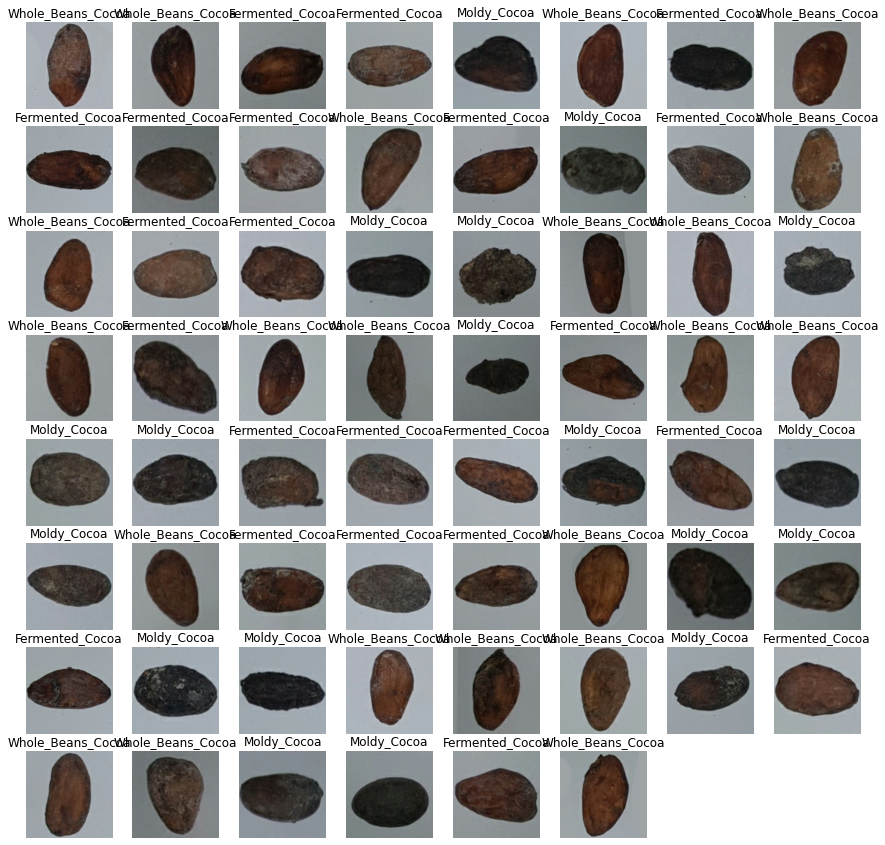

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
4/4 [==============================] - 21s 6s/step - loss: 2.1386 - accuracy: 0.3263
Epoch 2/30
4/4 [==============================] - 18s 4s/step - loss: 1.6982 - accuracy: 0.3421
Epoch 3/30
4/4 [==============================] - 18s 4s/step - loss: 1.2889 - accuracy: 0.3474
Epoch 4/30
4/4 [==============================] - 18s 4s/step - loss: 0.9838 - accuracy: 0.3684
Epoch 5/30
4/4 [==============================] - 18s 4s/step - loss: 0.7198 - accuracy: 0.6526
Epoch 6/30
4/4 [==============================] - 18s 6s/step - loss: 0.6662 - accuracy: 0.6737
Epoch 7/30
4/4 [==============================] - 18s 4s/step - loss: 1.5540 - accuracy: 0.5789
Epoch 8/30
4/4 [==============================] - 18s 4s/step - loss: 0.7066 - accuracy: 0.6368
Epoch 9/30
4/4 [==============================] - 21s 5s/step - loss: 0.6863 - accuracy: 0.6579
Epoch 10/30
4/4 [==============================] - 18s 4s/step - loss: 0.6774 - accuracy: 0.7737
Epoch 11/30
4/4 [======================

In [21]:
model.evaluate(test_ds)

2/2 [==============================] - 4s 2s/step - loss: 0.2207 - accuracy: 0.9274


[0.2206858992576599, 0.9274193644523621]

In [22]:
acc = history.history['accuracy']
loss = history.history['loss']

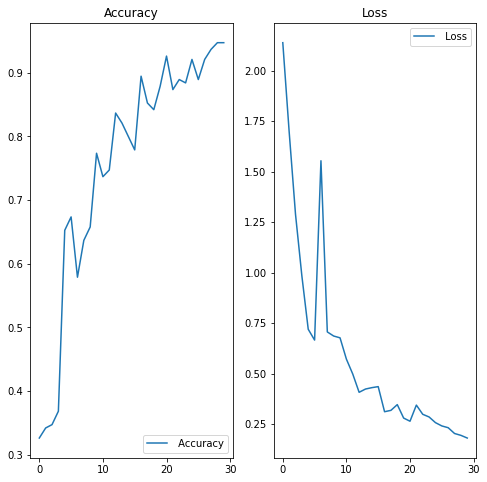

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

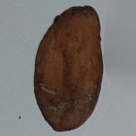

In [24]:
image_path = "/gdrive/My Drive/WB01_103.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [25]:
pred = model.predict(scaled_img)

In [26]:
output = class_names[np.argmax(pred)]

In [27]:
output

'Whole_Beans_Cocoa'

In [28]:
model.save("Cocoa beans Classification.h5")